# 2D Recovery with Binning Demo with Linear Bregman Iteration



by Xingjia Wang

Summary: The following notebook contains a demonstration of using Linear Bregman Iteration to recover a random 2D image (represented by a 2D numpy array) with binning.

## Unit Import

In [1]:
import numpy as np
import scipy.ndimage
import scipy.ndimage.filters as fi
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
from linBreg import *

## Used Functions

### Data Generating Functions

- gkern(kernlen=21, nsig=3): returns a 2D Gaussian Kernel
- applyK(K, n, loc=0, binsize=1): returns a sensing matrix with selected kernel

In [3]:
# Generating a 2d Gaussian kernel
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [4]:
# Function of applying kernel onto each pixel of an empty canvas that is of the same size as the ground truth and 
# Generates a sensing matrix

def applyK(K, n, loc = 0, binsize = 1):
    
    # loc = 0 or np.array((len, 2))
    
    if (type(loc) == int):
        A = np.zeros((pow(n//binsize,2), pow(n,2)))
        kernal_half_width = len(K)//2
        for xind in np.arange(0,n):
            for yind in np.arange(0,n):
                im = np.zeros((n,n))
                Ind = xind*n + yind
                im_x1 = np.max([xind - kernal_half_width, 0])
                im_x2 = np.min([xind + kernal_half_width, n])
                im_y1 = np.max([yind - kernal_half_width, 0])
                im_y2 = np.min([yind + kernal_half_width, n])

                k_x1 = kernal_half_width - (xind - im_x1)
                k_x2 = kernal_half_width + (im_x2 - xind)
                k_y1 = kernal_half_width - (yind - im_y1)
                k_y2 = kernal_half_width + (im_y2 - yind)

                im[im_x1:im_x2, im_y1:im_y2] = K[k_x1:k_x2, k_y1:k_y2]
                A[:,Ind]=binPixel(np.reshape(im, (n,n)), binsize).ravel()
    else:
        A = np.zeros((pow(n//binsize,2), len(loc)))
        #print(len(loc))
        kernal_half_width = len(K)//2
        Ind = 0
        for idx in loc:
            xind = idx[0]
            yind = idx[1]
            im = np.zeros((n,n))
            im_x1 = np.max([xind - kernal_half_width, 0])
            im_x2 = np.min([xind + kernal_half_width, n])
            im_y1 = np.max([yind - kernal_half_width, 0])
            im_y2 = np.min([yind + kernal_half_width, n])
            
            k_x1 = kernal_half_width - (xind - im_x1)
            k_x2 = kernal_half_width + (im_x2 - xind)
            k_y1 = kernal_half_width - (yind - im_y1)
            k_y2 = kernal_half_width + (im_y2 - yind)

            im[im_x1:im_x2, im_y1:im_y2] = K[k_x1:k_x2, k_y1:k_y2]
            A[:,Ind]=binPixel(np.reshape(im, (n,n)), binsize).ravel()
            Ind += 1
    return A

### Binning Functions

- binPixel(p, ind): returns a binned matrix

In [5]:
# Function of binning p by ind*ind pixels

def binPixel(p, ind):
    x = p.shape[0]
    y = p.shape[1]
    a1 = p.reshape((x*y//ind,ind)).sum(1).reshape(x,y//ind).transpose().reshape(x*y//ind//ind,ind).sum(1).reshape(y//ind,x//ind).transpose()
    return a1

## Simulation Run

### Data Initialization

In [6]:
n = 40
sig = 6
binsize = 4

In [7]:
# Generating a Gaussian Kernel
K = gkern(n+1, sig)

# Generating A
A = applyK(K, n)

# Generating a Ground Truth

imTest = np.zeros((n,n))
midpoint = int(np.ceil(n/2))
idx = np.random.randint(0,n-1,midpoint)
for i in idx:
    imTest[i][np.random.randint(0,n-1)] = np.random.rand()
    
# Generating the blur from sensing matrix
l = np.matmul(A, imTest.ravel())
im = l.reshape((n,n))

# Generating a binned sensing matrix
A_bin = applyK(K, n, 0, binsize)

# Binning the blur
im_bin = binPixel(im,binsize)

### Recovery without Binning

10000
20000
30000


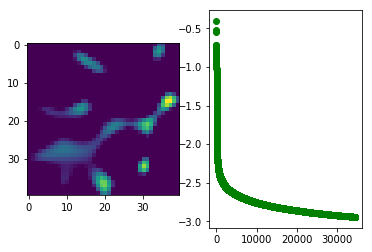

In [9]:
u = linbreg(l, A, threshold = 1e7, stepsize = 3e-8, maxstep = 7e4, crit = 1e-5)

### Recovery with Binning

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


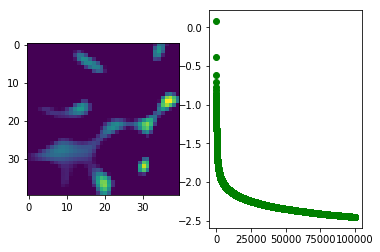

In [11]:
u_bin = linbreg(im_bin.ravel(), A_bin, threshold= 1e10, stepsize = 1e-11, maxstep = 5e4, crit = 1e-6)

## Results Visualization

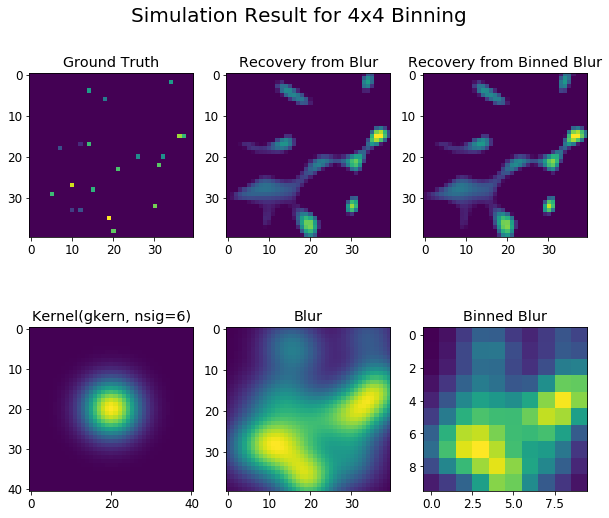

In [12]:
'''
Kernel, blur; sensing matrix check; gth check; recovery check; list of parameters
'''
font = {'family' : 'DejaVu Sans',
  'size' : 12}
plt.rc('font', **font)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8

ax0 = plt.subplot(231)
ax0.get_xaxis().set_label_position('bottom')
ax0.set_title("Ground Truth")
ax0.imshow(imTest)

ax1 = plt.subplot(232)
ax1.set_title("Recovery from Blur")
ax1.imshow(u)

ax2 = plt.subplot(233)
ax2.set_title( "Recovery from Binned Blur")
ax2.imshow(u_bin)

ax3 = plt.subplot(234)
ax3.set_title("Kernel(gkern, nsig={})".format(sig))
ax3.imshow(K)

ax4 = plt.subplot(235)
ax4.set_title("Blur")
ax4.imshow(im)

ax5 = plt.subplot(236)
ax5.set_title("Binned Blur")
ax5.imshow(im_bin)

plt.subplots_adjust(hspace=.4) 

plt.suptitle("Simulation Result for {}x{} Binning".format(binsize,binsize), size = 20)
plt.savefig("B_{}_NSig_{}_{}x{}.jpg".format(binsize,sig,n,n))
